## Convolutional Kolmogorov-Arnold Networks

Load thư viện và các model cần thiết

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


from architectures_28x28.SimpleModels import *
from architectures_28x28.KKAN import KKAN_Convolutional_Network

In [23]:
cKAN_10_epoch_model = KKAN_Convolutional_Network(device=device)
cKAN_10_epoch_model.load_state_dict(torch.load('models/cKAN_model_10_epoch/best_model.pth',weights_only=True, map_location=device))
cKAN_10_epoch_model.eval()  

KKAN_Convolutional_Network(
  (conv1): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0-4): 5 x KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (conv2): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0-4): 5 x KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (kan1): KANLinear(
    (base_activation): SiLU()
  )
)

In [13]:
modelCNN = SimpleCNN_2()
modelCNN.load_state_dict(torch.load('models/simpleCNN_2_model/best_model.pth', weights_only=True))
modelCNN.eval()  # Đặt mô hình ở chế độ đánh giá

SimpleCNN_2(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(5, 25, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=625, out_features=245, bias=True)
  (fc2): Linear(in_features=245, out_features=10, bias=True)
)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

Predicted: 5, Actual: 5


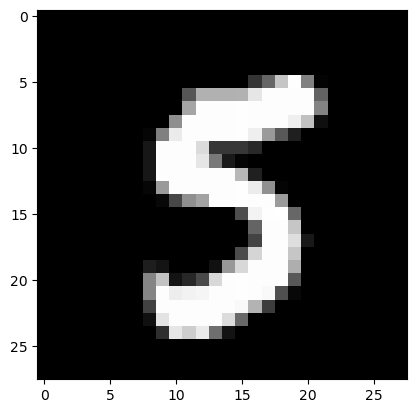

In [30]:
def predictFirstNumber(model, device, test_loader):
    model.to(device)
    model.eval()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            print(f'Predicted: {pred.item()}, Actual: {target.item()}')

            plt.imshow(data.cpu().squeeze().numpy(), cmap='gray')
            plt.show()
            break  

predictFirstNumber(cKAN_10_epoch_model, device, test_loader)

In [33]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels)
            all_preds.extend(predicted)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy, all_labels, all_preds

CNN Model Accuracy: 97.87%
cKAN Model Accuracy: 91.77%


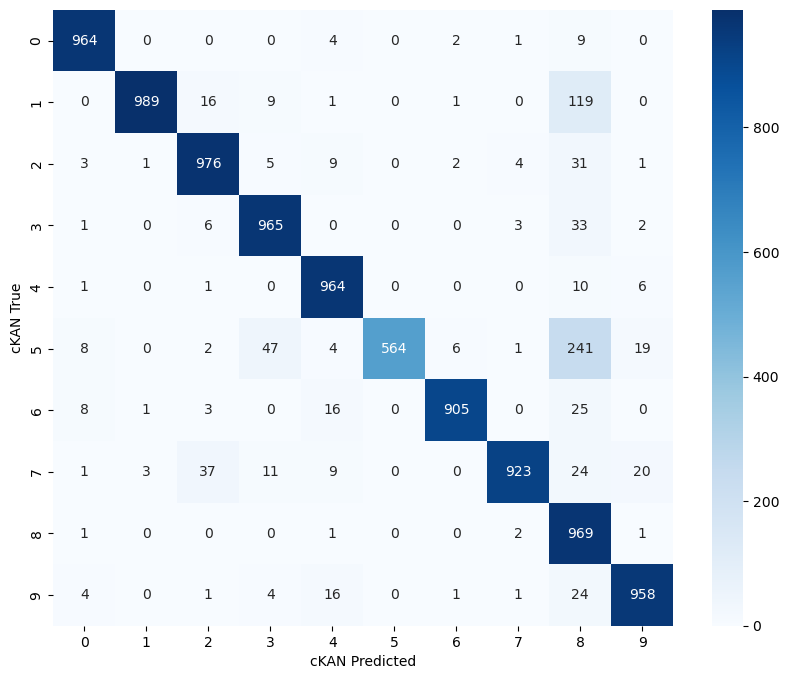

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cnn_accuracy, cnn_labels, cnn_preds = evaluate_model(modelCNN, test_loader)
print(f'CNN Model Accuracy: {cnn_accuracy * 100:.2f}%')

ckan_accuracy, ckan_labels, ckan_preds = evaluate_model(cKAN_10_epoch_model, test_loader)
print(f'cKAN Model Accuracy: {ckan_accuracy * 100:.2f}%')

ckan_cm = confusion_matrix(ckan_labels, ckan_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(ckan_cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('cKAN Predicted')
plt.ylabel('cKAN True')
plt.show()
